<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
# <font color='green'>OTIMIZAÇÃO DE HIPERPARÂMETROS DO XGBOOST COM AMAZON SAGEMAKER DA AWS</font>
## <font color='green'>DATA SCIENCE E CLOUD COMPUTING</font>

Este projeto envolve o uso de aprendizado supervisionado e otimização de hiperparâmetros do algorítimo XGboost utilizando o Amazon SageMaker da AWS (Cloud Computing) com o objetivo de descobrir as características que podem influenciar a qualidade de um vinho.

Fonte de dados: https://www.kaggle.com/datasets/xuzihe2010/wine-quality-red

## Instalar e Carregar Pacotes

In [1]:
!pip install -q seaborn

In [2]:
!pip install -q sagemaker

In [3]:
!pip install boto3

In [4]:
# Imports

# Manipulação de dados
import io  
import numpy as np
import pandas as pd

# Visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

# AWS
import boto3  
import sagemaker
from sagemaker.inputs import TrainingInput
from sagemaker import get_execution_role  
from sagemaker.tuner import HyperparameterTuner, IntegerParameter, ContinuousParameter

# Estatísticos
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Machine learning e matemática
import sklearn
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

# Salvar em disco
import pickle  # salvar em disco

import warnings
warnings.filterwarnings('ignore')

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [5]:
# Gravar versões de pacotes
!pip install -q -U watermark

In [6]:
# Versões dos pacotes
%reload_ext watermark
%watermark --iversions

sklearn    : 1.4.2
numpy      : 1.26.4
matplotlib : 3.8.4
sagemaker  : 2.214.3
pandas     : 2.1.4
seaborn    : 0.13.2
boto3      : 1.34.51
xgboost    : 1.7.6
statsmodels: 0.14.1



## Carregar e Organizar os Dados

In [7]:
# Bucket S3 criado pelo SageMaker
bucket_name = 'sagemaker-studio-976193244061-3wez3e8mn6x'

In [8]:
# Conexão ao S3
s3_client = boto3.client('s3')

In [9]:
# Lista dos arquivos
files = ['dataset_1.csv', 'dataset_2.csv']  

In [10]:
# Download dos arquivos que estão no S3
for i, key in enumerate(files):
    local_filename = f'dataset_{i+1}.csv'  
    s3_client.download_file(bucket_name, key, local_filename)

In [11]:
# Carregar arquivos
white_wine_df = pd.read_csv('dataset_1.csv')
red_wine_df = pd.read_csv('dataset_2.csv')

In [12]:
white_wine_df.head()

,"fixed acidity;""volatile acidity"";""citric acid"";""residual sugar"";""chlorides"";""free sulfur dioxide"";""total sulfur dioxide"";""density"";""pH"";""sulphates"";""alcohol"";""quality"""
0,7;0.27;0.36;20.7;0.045;45;170;1.001;3;0.45;8.8;6
1,6.3;0.3;0.34;1.6;0.049;14;132;0.994;3.3;0.49;9...
2,8.1;0.28;0.4;6.9;0.05;30;97;0.9951;3.26;0.44;1...
3,7.2;0.23;0.32;8.5;0.058;47;186;0.9956;3.19;0.4...
4,7.2;0.23;0.32;8.5;0.058;47;186;0.9956;3.19;0.4...


In [13]:
red_wine_df.head()

,"fixed acidity;""volatile acidity"";""citric acid"";""residual sugar"";""chlorides"";""free sulfur dioxide"";""total sulfur dioxide"";""density"";""pH"";""sulphates"";""alcohol"";""quality"""
0,7.4;0.7;0;1.9;0.076;11;34;0.9978;3.51;0.56;9.4;5
1,7.8;0.88;0;2.6;0.098;25;67;0.9968;3.2;0.68;9.8;5
2,7.8;0.76;0.04;2.3;0.092;15;54;0.997;3.26;0.65;...
3,11.2;0.28;0.56;1.9;0.075;17;60;0.998;3.16;0.58...
4,7.4;0.7;0;1.9;0.076;11;34;0.9978;3.51;0.56;9.4;5


**Diagnóstico:** Os nomes das variáveis precisam ser ajustados.

**Ação:** Austar os nomes das variáveis.

In [14]:
# Nomes das variáveis
white_wine_df = white_wine_df['fixed acidity;"volatile acidity";"citric acid";"residual sugar";"chlorides";"free sulfur dioxide";"total sulfur dioxide";"density";"pH";"sulphates";"alcohol";"quality"'].str.split(';', expand=True)

In [15]:
# Nomes das variáveis
red_wine_df = red_wine_df['fixed acidity;"volatile acidity";"citric acid";"residual sugar";"chlorides";"free sulfur dioxide";"total sulfur dioxide";"density";"pH";"sulphates";"alcohol";"quality"'].str.split(';', expand=True)

In [16]:
# Ajustar os nomes da variáveis
columns_name = ['fixed acidity', 
                 'volatile acidity', 
                 'citric acid', 
                 'residual sugar',
                 'chlorides', 
                 'free sulfur dioxide', 
                 'total sulfur dioxide', 
                 'density',
                 'pH', 
                 'sulphates', 
                 'alcohol', 
                 'quality']

In [17]:
# Renomear os nomes das variáveis
white_wine_df.columns = columns_name
red_wine_df.columns = columns_name

In [18]:
white_wine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7,0.27,0.36,20.7,0.045,45,170,1.001,3,0.45,8.8,6
1,6.3,0.3,0.34,1.6,0.049,14,132,0.994,3.3,0.49,9.5,6
2,8.1,0.28,0.4,6.9,0.05,30,97,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.4,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.4,9.9,6


In [19]:
red_wine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.7,0,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0,2.6,0.098,25,67,0.9968,3.2,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15,54,0.997,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17,60,0.998,3.16,0.58,9.8,6
4,7.4,0.7,0,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5


In [20]:
# Adiciona uma coluna em cada dataframe com o tipo do vinho
white_wine_df['wine_type'] = 'white'
red_wine_df['wine_type'] = 'red'

In [21]:
# Merge dos dataframes
merged_df = pd.concat([white_wine_df, red_wine_df], ignore_index = True)

**Ação:** Realizar a junção (merge) dos dois datasets.

**Justificativa:** Otimizar os hiperparâmetros considerando simultaneamente as variáveis dos vinhos branco e tinto.

In [22]:
merged_df.shape

(6497, 13)

In [23]:
merged_df.sample(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type
5866,9,0.4,0.43,2.4,0.068,29,46,0.9943,3.2,0.6,12.2,6,red
3863,6.5,0.27,0.19,6.6,0.045,98,175,0.99364,3.16,0.34,10.1,6,white
5372,10.5,0.28,0.51,1.7,0.08,10,24,0.9982,3.2,0.89,9.4,6,red
4841,5.7,0.22,0.25,1.1,0.05,97,175,0.99099,3.44,0.62,11.1,6,white
3915,4.7,0.455,0.18,1.9,0.036,33,106,0.98746,3.21,0.83,14,7,white


In [24]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   fixed acidity         6497 non-null   object
 1   volatile acidity      6497 non-null   object
 2   citric acid           6497 non-null   object
 3   residual sugar        6497 non-null   object
 4   chlorides             6497 non-null   object
 5   free sulfur dioxide   6497 non-null   object
 6   total sulfur dioxide  6497 non-null   object
 7   density               6497 non-null   object
 8   pH                    6497 non-null   object
 9   sulphates             6497 non-null   object
 10  alcohol               6497 non-null   object
 11  quality               6497 non-null   object
 12  wine_type             6497 non-null   object
dtypes: object(13)
memory usage: 660.0+ KB


In [25]:
# Converter o tipo object para float (com exceção da coluna wine_type)
for column in merged_df.columns:
    
    # Exclui a coluna de tipo
    if column != 'wine_type':
        
        # Converte de strings para floats
        merged_df[column] = merged_df[column].astype(float)

In [26]:
merged_df.sample(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type
3369,7.0,0.220,0.28,10.6,0.039,32.0,117.0,0.99355,3.05,0.55,11.5,7.0,white
4975,6.8,0.785,0.00,2.4,0.104,14.0,30.0,0.99660,3.52,0.55,10.7,6.0,red
3273,6.4,0.230,0.32,1.9,0.038,40.0,118.0,0.99074,3.32,0.53,11.8,7.0,white
223,6.5,0.190,0.30,0.8,0.043,33.0,144.0,0.99360,3.42,0.39,9.1,6.0,white
3951,6.3,0.330,0.20,17.9,0.066,36.0,161.0,0.99910,3.14,0.51,8.8,5.0,white
1871,7.0,0.210,0.22,5.1,0.048,38.0,168.0,0.99450,3.34,0.49,10.4,6.0,white
1011,7.7,0.160,0.41,1.7,0.048,60.0,173.0,0.99320,3.24,0.66,11.2,7.0,white
5800,7.4,0.635,0.10,2.4,0.080,16.0,33.0,0.99736,3.58,0.69,10.8,7.0,red
4482,6.2,0.300,0.33,3.5,0.037,37.0,155.0,0.98987,3.18,0.37,12.4,6.0,white
5560,7.2,0.570,0.06,1.6,0.076,9.0,27.0,0.99720,3.36,0.70,9.6,6.0,red


In [27]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   float64
 12  wine_type             6497 non-null   object 
dtypes: float64(12), object(1)
memory usage: 660.0+ KB


## Análise Exploratória de Dados

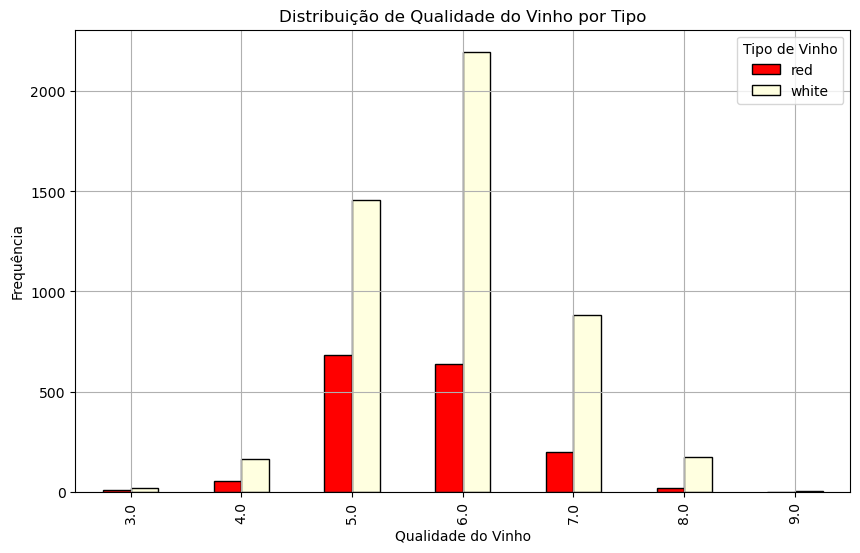

In [28]:
# Plot
value_counts = merged_df.groupby(['quality', 'wine_type']).size().unstack(fill_value=0)

value_counts.plot(kind='bar', stacked=False, color=['red', 'lightyellow'], edgecolor='black', figsize=(10, 6))
plt.xlabel('Qualidade do Vinho')
plt.ylabel('Frequência')
plt.title('Distribuição de Qualidade do Vinho por Tipo')
plt.grid(True)
plt.legend(title='Tipo de Vinho', loc='upper right')
plt.show()

**Diagnóstico:** Observa-se que, em geral, o vinho branco apresenta um índice de qualidade superior.

**Ação:** Manter o junção dos datasets.

**Justificativa:** O objetivo do projeto é otimizar os hiperparâmetros de ambos os datasets de forma simultânea. No entanto,
em um projeto futuro, caso o foco da área de negócio seja diferente, os datasets poderiam ser analisados separadamente.

In [29]:
# Drop da coluna não numérica
numeric_df = merged_df.drop(columns = ['wine_type'])

In [30]:
numeric_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   float64
dtypes: float64(12)
memory usage: 609.2 KB


In [31]:
# Cria a matriz de correlação
correlation_matrix = numeric_df.corr()

In [32]:
# Print da matriz
print("Matriz de Correlação:")
correlation_matrix.head()

Matriz de Correlação:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,0.219008,0.324436,-0.111981,0.298195,-0.282735,-0.329054,0.458910,-0.252700,0.299568,-0.095452,-0.076743
volatile acidity,0.219008,1.000000,-0.377981,-0.196011,0.377124,-0.352557,-0.414476,0.271296,0.261454,0.225984,-0.037640,-0.265699
citric acid,0.324436,-0.377981,1.000000,0.142451,0.038998,0.133126,0.195242,0.096154,-0.329808,0.056197,-0.010493,0.085532
residual sugar,-0.111981,-0.196011,0.142451,1.000000,-0.128940,0.402871,0.495482,0.552517,-0.267320,-0.185927,-0.359415,-0.036980
chlorides,0.298195,0.377124,0.038998,-0.128940,1.000000,-0.195045,-0.279630,0.362615,0.044708,0.395593,-0.256916,-0.200666


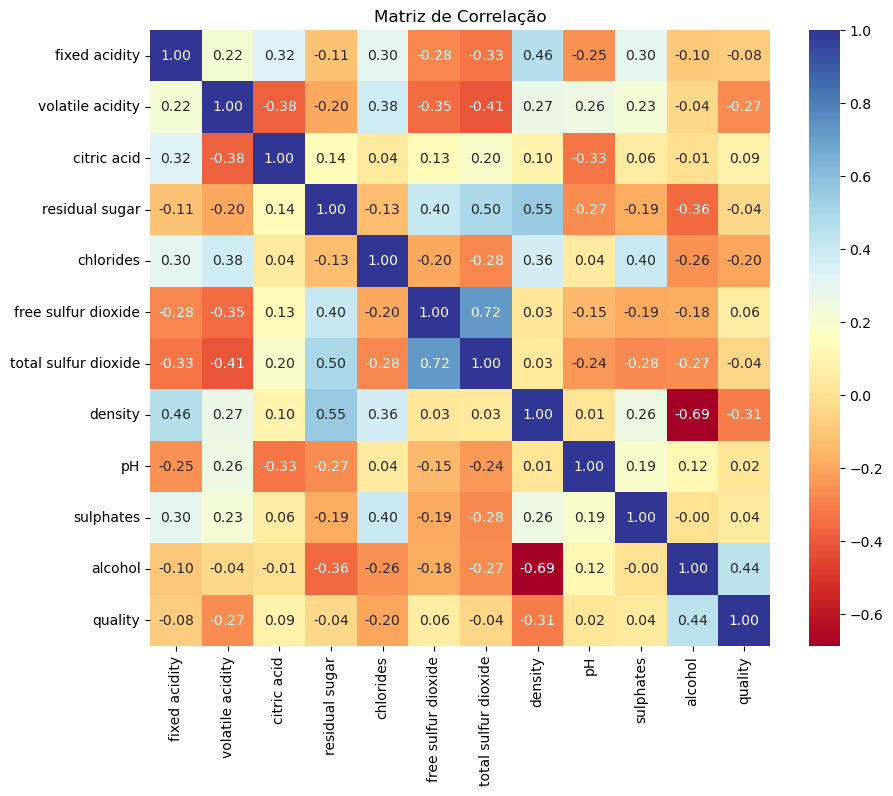

In [33]:
# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlBu', fmt=".2f")
plt.title('Matriz de Correlação')
plt.show()

In [34]:
# Ordena os dados
quality_correlations = correlation_matrix['quality'].sort_values(ascending = False)
quality_correlations

quality                 1.000000
alcohol                 0.444319
citric acid             0.085532
free sulfur dioxide     0.055463
sulphates               0.038485
pH                      0.019506
residual sugar         -0.036980
total sulfur dioxide   -0.041385
fixed acidity          -0.076743
chlorides              -0.200666
volatile acidity       -0.265699
density                -0.305858
Name: quality, dtype: float64

### CARACTERÍSTICAS QUE INFLUENCIAM A QUALIDADE DE UM VINHO
**RELATÓRIO**


O resultado da matriz de correlação mostra a correlação de diversas variáveis com a variável dependente quality, que representa a qualidade do vinho. A correlação varia entre -1 e 1, onde:

Correlação positiva (+): As variáveis aumentam juntas.
Correlação negativa (-): À medida que uma variável aumenta, a outra tende a diminuir.
Correlação próxima de 0: Indica pouca ou nenhuma relação linear entre as variáveis.

Interpretando cada correlação com quality:
1. alcohol (0.444319)
Esta é a correlação mais alta e positiva. Indica que, à medida que o teor alcoólico aumenta, a qualidade do produto também tende a aumentar. Com uma correlação de 0.44, há uma relação moderada, **sugerindo que o teor alcoólico pode ser um fator importante na qualidade.
2. citric acid (0.085532)
A correlação é positiva, mas muito baixa. Isso indica que o ácido cítrico tem uma influência quase desprezível na qualidade. Sua contribuição é mínima.
3. free sulfur dioxide (0.055463)
A correlação positiva e baixa sugere que o dióxido de enxofre livre tem pouca ou nenhuma relação com a qualidade.
4. sulphates (0.038485)
Correlação praticamente neutra e positiva. Os sulfatos têm um impacto muito pequeno na qualidade.
5. pH (0.019506)
A correlação de 0.019 é próxima de zero, o que indica que o pH não tem praticamente nenhuma relação com a qualidade.
6. residual sugar (-0.036980)
Correlação negativa e muito baixa. O açúcar residual tem um impacto quase insignificante, **sugerindo que, à medida que o açúcar residual aumenta, a qualidade tende a diminuir levemente, mas essa relação é muito fraca.
7. total sulfur dioxide (-0.041385)
A correlação de -0.041 também é muito baixa, sugerindo que o dióxido de enxofre total tem uma influência mínima e negativa na qualidade.
8. fixed acidity (-0.076743)
A acidez fixa tem uma correlação negativa fraca com a qualidade. **Isso sugere que níveis mais altos de acidez fixa podem estar ligeiramente associados a uma qualidade inferior.
9. chlorides (-0.200666)
A correlação de -0.201 indica uma relação negativa moderada. Isso sugere que quanto maior o nível de cloretos, menor tende a ser a qualidade. Embora não seja uma correlação muito forte, **é uma relação que vale a pena observar.
10. volatile acidity (-0.265699)
A correlação negativa de -0.266 é significativa. **Isso indica que a acidez volátil está moderadamente associada a uma queda na qualidade. Este fator pode ter um impacto relevante na avaliação da qualidade.
11. density (-0.305858)
**Esta é a correlação negativa mais forte (-0.306). Isso indica que quanto maior a densidade, menor tende a ser a qualidade. Densidade pode ser um fator importante para entender a variação da qualidade, possivelmente por estar associada a outros aspectos da composição química do produto.

In [35]:
#from statsmodels.stats.outliers_influence import variance_inflation_factor
#from statsmodels.tools.tools import add_constant

# Adicionando uma constante (intercepto) para calcular VIF
X = add_constant(numeric_df)

# Calculando o VIF para cada variável
vif = pd.DataFrame()
vif["Variável"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)

                Variável           VIF
0                  const  1.705545e+06
1          fixed acidity  4.911189e+00
2       volatile acidity  2.037955e+00
3            citric acid  1.608690e+00
4         residual sugar  7.308546e+00
5              chlorides  1.632490e+00
6    free sulfur dioxide  2.156281e+00
7   total sulfur dioxide  2.974040e+00
8                density  1.596483e+01
9                     pH  2.545764e+00
10             sulphates  1.565737e+00
11               alcohol  4.970044e+00
12               quality  1.412703e+00


**Análise e Ingigths:**

A interpretação dos resultados do Fator de Inflação da Variância (VIF) é crucial para avaliar a multicolinearidade entre as variáveis independentes em um modelo de regressão. O VIF mede o quanto a variância de um coeficiente de regressão é inflacionada devido à correlação com outras variáveis do modelo. Em geral:

VIF = 1: Não há correlação entre a variável e as demais.
1 < VIF < 5: Correlação moderada (aceitável).
VIF > 5: Indica correlação elevada e possível multicolinearidade problemática.
VIF > 10: Multicolinearidade severa.

Interpretando os resultados:

A maioria das variáveis tem VIFs aceitáveis, com exceção de:

O valor extremamente alto de VIF da constante (const) não é um problema de multicolinearidade entre as variáveis, mas sim um efeito técnico que ocorre porque a constante não é uma variável explicativa. Pode ser ignorado.
density (15.96): Altamente correlacionada com outras variáveis, como residual sugar e alcohol, sugerindo multicolinearidade severa. Poderíamos considerar removê-la do modelo ou usar técnicas como PCA (Análise de Componentes Principais) para reduzir a multicolinearidade.
residual sugar (7.31): Está em um nível mais alto de multicolinearidade, mas ainda não crítico.

**Decisão:** O algorítmos XGboost trabalha bem com datasets com problemas de multicolinearidade e vamos prosseguir sem aplicar o PCA.

## Detecção de Outliers

In [36]:
# Identificando as variáveis numéricas
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   float64
 12  wine_type             6497 non-null   object 
dtypes: float64(12), object(1)
memory usage: 660.0+ KB


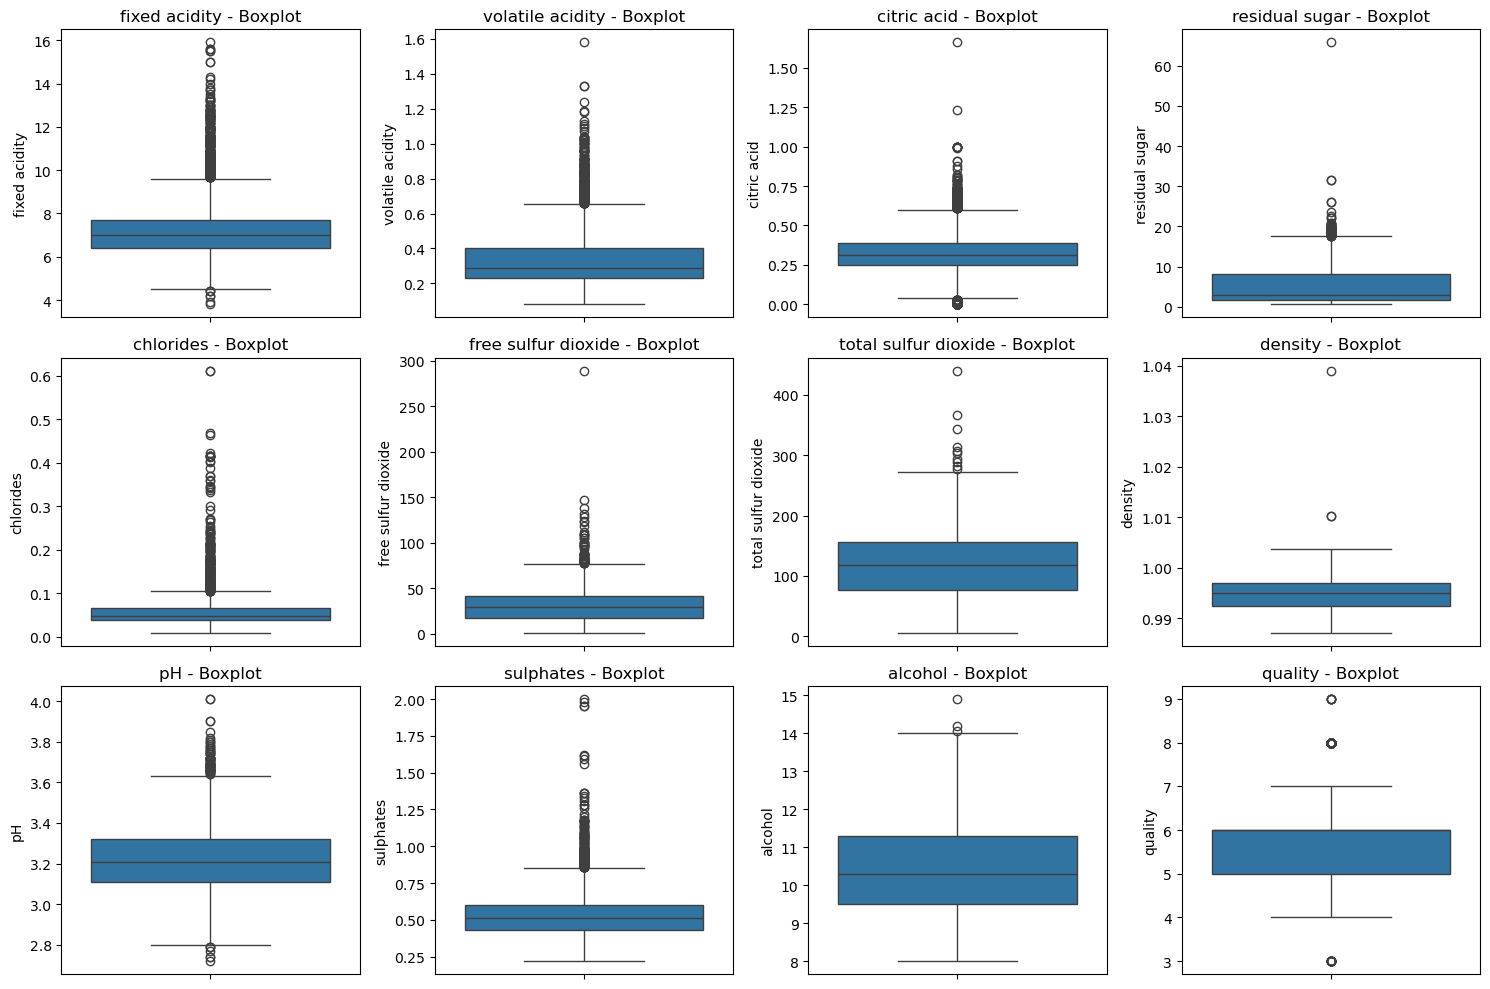

In [37]:
# Boxplot das variáveis numéricas

# Define o número de colunas e linhas
num_cols = 4  
num_rows = math.ceil(len(merged_df.columns.drop('wine_type')) / num_cols)  

# Cria os subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 10))

# Flatten dos eixos
axs = axs.ravel()

# Cria um boxplot para cada variável, exceto 'wine_type'
for idx, col in enumerate(merged_df.columns):
    if col != 'wine_type':
        sns.boxplot(data=merged_df, y=col, ax=axs[idx])
        axs[idx].set_title(f'{col} - Boxplot')

# Desliga os eixos restantes, se necessário
for ax in axs[idx + 1:]:
    ax.axis('off')

# Ajusta o layout
plt.tight_layout()
plt.show()

In [38]:
# Seleciona as colunas numéricas para detecção de outliers
numerical_columns = merged_df.select_dtypes('number').columns

In [39]:
# Intervalo Interquartil de cada variável
Q1 = merged_df[numerical_columns].quantile(0.25)
Q3 = merged_df[numerical_columns].quantile(0.75)
IQR = Q3 - Q1

In [40]:
# Define os limites superior e inferior
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [41]:
# Identifica potenciais outliers
potential_outliers = ((merged_df[numerical_columns] < lower_bound) | (merged_df[numerical_columns] > upper_bound))

In [42]:
# Filtra o dataframe
outliers_df = merged_df[potential_outliers.any(axis = 1)]

In [43]:
# Outliers em cada variável
outlier_counts = potential_outliers.sum()
outlier_counts

fixed acidity           357
volatile acidity        377
citric acid             509
residual sugar          118
chlorides               286
free sulfur dioxide      62
total sulfur dioxide     10
density                   3
pH                       73
sulphates               191
alcohol                   3
quality                 228
dtype: int64

In [44]:
# Percentual de outliers em cada variável
percentual = outlier_counts / len(merged_df) * 100
percentual

fixed acidity           5.494844
volatile acidity        5.802678
citric acid             7.834385
residual sugar          1.816223
chlorides               4.402032
free sulfur dioxide     0.954287
total sulfur dioxide    0.153917
density                 0.046175
pH                      1.123596
sulphates               2.939818
alcohol                 0.046175
quality                 3.509312
dtype: float64

**Análise & Insights:**
De maneira geral, o percentual de outliers presentes nas variáveis é baixo.

**Decisão:**
Prosseguiremos sem a remoção dos outliers, uma vez que o algoritmo XGBoost é robusto e lida bem com a presença de outliers em seus dados.

## Divisão em Dados de Treino, Validação e Teste

In [45]:
dados_treino, dados_temp = train_test_split(merged_df, test_size = 0.3, random_state = 42)

In [46]:
dados_valid, dados_teste = train_test_split(dados_temp, test_size = 0.5, random_state = 42)

## Padronização

In [47]:
dados_treino.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type
3761,6.1,0.17,0.28,2.5,0.028,22.0,98.0,0.99072,3.16,0.37,11.1,7.0,white
3740,7.0,0.15,0.28,14.7,0.051,29.0,149.0,0.99792,2.96,0.39,9.0,7.0,white
1359,6.5,0.19,0.32,1.4,0.040,31.0,132.0,0.99220,3.36,0.54,10.8,7.0,white
1230,7.3,0.29,0.30,13.0,0.043,46.0,238.0,0.99860,3.06,0.41,8.7,6.0,white
4751,7.3,0.36,0.62,7.1,0.033,48.0,185.0,0.99472,3.14,0.62,10.6,6.0,white


In [48]:
# Lista de colunas numéricas excluindo a variável alvo (qualidade)
colunas_numericas_treino = dados_treino.select_dtypes(include = [np.number]).drop(columns = ['quality']).columns

In [49]:
# Lista de colunas numéricas excluindo a variável alvo (qualidade)
colunas_numericas_valid = dados_valid.select_dtypes(include = [np.number]).drop(columns = ['quality']).columns

In [50]:
# Lista de colunas numéricas excluindo a variável alvo (qualidade)
colunas_numericas_teste = dados_teste.select_dtypes(include = [np.number]).drop(columns = ['quality']).columns

In [51]:
# Cria o objeto de padronização responsável por normalizar os dados(escala as variáveis entre 0 e 1)
scaler = MinMaxScaler() 

In [52]:
# Fit e transform em treino
dados_treino[colunas_numericas_treino] = scaler.fit_transform(dados_treino[colunas_numericas_treino])

In [53]:
# Apenas transform em validação
dados_valid[colunas_numericas_valid] = scaler.transform(dados_valid[colunas_numericas_valid])

In [54]:
# Apenas transform em teste
dados_teste[colunas_numericas_teste] = scaler.transform(dados_teste[colunas_numericas_teste])

In [55]:
dados_treino.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type
3761,0.190083,0.060000,0.168675,0.061290,0.026711,0.144330,0.255201,0.154942,0.372881,0.080000,0.449275,7.0,white
3740,0.264463,0.046667,0.168675,0.454839,0.065109,0.192440,0.396671,0.465688,0.203390,0.091429,0.144928,7.0,white
1359,0.223140,0.073333,0.192771,0.025806,0.046745,0.206186,0.349515,0.218817,0.542373,0.177143,0.405797,7.0,white
1230,0.289256,0.140000,0.180723,0.400000,0.051753,0.309278,0.643551,0.495037,0.288136,0.102857,0.101449,6.0,white
4751,0.289256,0.186667,0.373494,0.209677,0.035058,0.323024,0.496533,0.327579,0.355932,0.222857,0.376812,6.0,white


In [56]:
dados_valid.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type
5169,0.636364,0.066667,0.307229,0.109677,0.153589,0.020619,0.047157,0.538196,0.474576,0.422857,0.304348,6.0,red
6388,0.272727,0.093333,0.295181,0.038710,0.045075,0.048110,0.033287,0.272335,0.567797,0.188571,0.637681,6.0,red
4371,0.264463,0.100000,0.168675,0.067742,0.068447,0.103093,0.238558,0.284420,0.389831,0.188571,0.188406,5.0,white
1414,0.165289,0.060000,0.180723,0.025806,0.041736,0.371134,0.343967,0.162710,0.483051,0.085714,0.478261,6.0,white
1738,0.305785,0.046667,0.228916,0.038710,0.070117,0.123711,0.263523,0.322400,0.440678,0.120000,0.289855,5.0,white


In [57]:
dados_teste.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type
4221,0.206612,0.133333,0.204819,0.241935,0.043406,0.295533,0.341193,0.230902,0.457627,0.034286,0.594203,6.0,white
4500,0.330579,0.126667,0.198795,0.058065,0.068447,0.240550,0.468793,0.210186,0.406780,0.182857,0.434783,6.0,white
5589,0.446281,0.560000,0.144578,0.064516,0.125209,0.075601,0.241331,0.546828,0.644068,0.177143,0.260870,5.0,red
2629,0.165289,0.346667,0.000000,0.022581,0.053422,0.487973,0.529820,0.211049,0.711864,0.114286,0.420290,5.0,white
3410,0.421488,0.146667,0.210843,0.129032,0.033389,0.213058,0.393897,0.321536,0.364407,0.125714,0.507246,7.0,white


## Variáveis Dummy com One-Hot-Encode
#### Tratar a variável categórica para numérica

In [58]:
# Cria as variáveis dummy 'wine_type_red' e wine_type_white
dados_treino = pd.get_dummies(data = dados_treino, columns = ['wine_type'])

In [59]:
dados_treino.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type_red,wine_type_white
3761,0.190083,0.060000,0.168675,0.061290,0.026711,0.144330,0.255201,0.154942,0.372881,0.080000,0.449275,7.0,False,True
3740,0.264463,0.046667,0.168675,0.454839,0.065109,0.192440,0.396671,0.465688,0.203390,0.091429,0.144928,7.0,False,True
1359,0.223140,0.073333,0.192771,0.025806,0.046745,0.206186,0.349515,0.218817,0.542373,0.177143,0.405797,7.0,False,True
1230,0.289256,0.140000,0.180723,0.400000,0.051753,0.309278,0.643551,0.495037,0.288136,0.102857,0.101449,6.0,False,True
4751,0.289256,0.186667,0.373494,0.209677,0.035058,0.323024,0.496533,0.327579,0.355932,0.222857,0.376812,6.0,False,True


In [60]:
dados_valid = pd.get_dummies(data = dados_valid, columns = ['wine_type'])

In [61]:
dados_teste = pd.get_dummies(data = dados_teste, columns = ['wine_type'])

In [62]:
# Converter valor booleano para inteiro
dados_treino[['wine_type_white', 'wine_type_red']] = dados_treino[['wine_type_white', 'wine_type_red']].astype(int)

In [63]:
dados_treino.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type_red,wine_type_white
3761,0.190083,0.060000,0.168675,0.061290,0.026711,0.144330,0.255201,0.154942,0.372881,0.080000,0.449275,7.0,0,1
3740,0.264463,0.046667,0.168675,0.454839,0.065109,0.192440,0.396671,0.465688,0.203390,0.091429,0.144928,7.0,0,1
1359,0.223140,0.073333,0.192771,0.025806,0.046745,0.206186,0.349515,0.218817,0.542373,0.177143,0.405797,7.0,0,1
1230,0.289256,0.140000,0.180723,0.400000,0.051753,0.309278,0.643551,0.495037,0.288136,0.102857,0.101449,6.0,0,1
4751,0.289256,0.186667,0.373494,0.209677,0.035058,0.323024,0.496533,0.327579,0.355932,0.222857,0.376812,6.0,0,1


In [64]:
# Converter valor booleano para inteiro
dados_valid[['wine_type_white', 'wine_type_red']] = dados_valid[['wine_type_white', 'wine_type_red']].astype(int)

In [65]:
dados_valid.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type_red,wine_type_white
5169,0.636364,0.066667,0.307229,0.109677,0.153589,0.020619,0.047157,0.538196,0.474576,0.422857,0.304348,6.0,1,0
6388,0.272727,0.093333,0.295181,0.038710,0.045075,0.048110,0.033287,0.272335,0.567797,0.188571,0.637681,6.0,1,0
4371,0.264463,0.100000,0.168675,0.067742,0.068447,0.103093,0.238558,0.284420,0.389831,0.188571,0.188406,5.0,0,1
1414,0.165289,0.060000,0.180723,0.025806,0.041736,0.371134,0.343967,0.162710,0.483051,0.085714,0.478261,6.0,0,1
1738,0.305785,0.046667,0.228916,0.038710,0.070117,0.123711,0.263523,0.322400,0.440678,0.120000,0.289855,5.0,0,1


In [66]:
# Converter valor booleano para inteiro
dados_teste[['wine_type_white', 'wine_type_red']] = dados_teste[['wine_type_white', 'wine_type_red']].astype(int)

In [67]:
dados_teste.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type_red,wine_type_white
4221,0.206612,0.133333,0.204819,0.241935,0.043406,0.295533,0.341193,0.230902,0.457627,0.034286,0.594203,6.0,0,1
4500,0.330579,0.126667,0.198795,0.058065,0.068447,0.240550,0.468793,0.210186,0.406780,0.182857,0.434783,6.0,0,1
5589,0.446281,0.560000,0.144578,0.064516,0.125209,0.075601,0.241331,0.546828,0.644068,0.177143,0.260870,5.0,1,0
2629,0.165289,0.346667,0.000000,0.022581,0.053422,0.487973,0.529820,0.211049,0.711864,0.114286,0.420290,5.0,0,1
3410,0.421488,0.146667,0.210843,0.129032,0.033389,0.213058,0.393897,0.321536,0.364407,0.125714,0.507246,7.0,0,1


In [68]:
# Colocamos a variável alvo no começo do dataframe
quality_column = dados_treino['quality']
dados_treino.drop(columns = ['quality'], inplace = True)
dados_treino.insert(0, 'quality', quality_column)

In [69]:
dados_treino.head()

,quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,wine_type_red,wine_type_white
3761,7.0,0.190083,0.060000,0.168675,0.061290,0.026711,0.144330,0.255201,0.154942,0.372881,0.080000,0.449275,0,1
3740,7.0,0.264463,0.046667,0.168675,0.454839,0.065109,0.192440,0.396671,0.465688,0.203390,0.091429,0.144928,0,1
1359,7.0,0.223140,0.073333,0.192771,0.025806,0.046745,0.206186,0.349515,0.218817,0.542373,0.177143,0.405797,0,1
1230,6.0,0.289256,0.140000,0.180723,0.400000,0.051753,0.309278,0.643551,0.495037,0.288136,0.102857,0.101449,0,1
4751,6.0,0.289256,0.186667,0.373494,0.209677,0.035058,0.323024,0.496533,0.327579,0.355932,0.222857,0.376812,0,1


In [70]:
# Colocara variável alvo no começo do dataframe
quality_column = dados_valid['quality']
dados_valid.drop(columns = ['quality'], inplace = True)
dados_valid.insert(0, 'quality', quality_column)

In [71]:
dados_valid.head()

,quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,wine_type_red,wine_type_white
5169,6.0,0.636364,0.066667,0.307229,0.109677,0.153589,0.020619,0.047157,0.538196,0.474576,0.422857,0.304348,1,0
6388,6.0,0.272727,0.093333,0.295181,0.038710,0.045075,0.048110,0.033287,0.272335,0.567797,0.188571,0.637681,1,0
4371,5.0,0.264463,0.100000,0.168675,0.067742,0.068447,0.103093,0.238558,0.284420,0.389831,0.188571,0.188406,0,1
1414,6.0,0.165289,0.060000,0.180723,0.025806,0.041736,0.371134,0.343967,0.162710,0.483051,0.085714,0.478261,0,1
1738,5.0,0.305785,0.046667,0.228916,0.038710,0.070117,0.123711,0.263523,0.322400,0.440678,0.120000,0.289855,0,1


In [72]:
# Colocar a variável alvo no começo do dataframe
quality_column = dados_teste['quality']
dados_teste.drop(columns = ['quality'], inplace = True)
dados_teste.insert(0, 'quality', quality_column)

In [73]:
dados_teste.head()

,quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,wine_type_red,wine_type_white
4221,6.0,0.206612,0.133333,0.204819,0.241935,0.043406,0.295533,0.341193,0.230902,0.457627,0.034286,0.594203,0,1
4500,6.0,0.330579,0.126667,0.198795,0.058065,0.068447,0.240550,0.468793,0.210186,0.406780,0.182857,0.434783,0,1
5589,5.0,0.446281,0.560000,0.144578,0.064516,0.125209,0.075601,0.241331,0.546828,0.644068,0.177143,0.260870,1,0
2629,5.0,0.165289,0.346667,0.000000,0.022581,0.053422,0.487973,0.529820,0.211049,0.711864,0.114286,0.420290,0,1
3410,7.0,0.421488,0.146667,0.210843,0.129032,0.033389,0.213058,0.393897,0.321536,0.364407,0.125714,0.507246,0,1


In [74]:
# Shape dos datasets
print("Shape dos Dados de Treino:", dados_treino.shape)
print("Shape dos Dados de Validação:", dados_valid.shape)
print("Shape dos Dados de Teste:", dados_teste.shape)

Shape dos Dados de Treino: (4547, 14)
Shape dos Dados de Validação: (975, 14)
Shape dos Dados de Teste: (975, 14)


## Convertendo os Dataframes para CSV na Memória

In [75]:
# Converte os dataframes para o formato CSV na memória
dados_treino_buffer = io.StringIO()
dados_treino.to_csv(dados_treino_buffer, index = False)
dados_treino_buffer.seek(0)

dados_valid_buffer = io.StringIO()
dados_valid.to_csv(dados_valid_buffer, index = False)
dados_valid_buffer.seek(0)

dados_teste_buffer = io.StringIO()
dados_teste.to_csv(dados_teste_buffer, index = False)
dados_teste_buffer.seek(0)

0

## Gravando os Arquivos Processados no S3

In [76]:
# Upload dos arquivos CSV para S3 por meio de código Python
s3_client.put_object(Body = dados_treino_buffer.getvalue(), Bucket = bucket_name, Key = 'dados_treino.csv')
s3_client.put_object(Body = dados_valid_buffer.getvalue(), Bucket = bucket_name, Key = 'dados_valid.csv')
s3_client.put_object(Body = dados_teste_buffer.getvalue(), Bucket = bucket_name, Key = 'dados_teste.csv')

{'ResponseMetadata': {'RequestId': 'NH5RGB1J34KMQWNM',
  'HostId': 'ir5zYCXgE0xPCwBZFjkBCq6m1Toz2iwPrOf+eBdufbg/ev5Mvyr7BKCcw6L/bPw9lySudTiSGBc=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'ir5zYCXgE0xPCwBZFjkBCq6m1Toz2iwPrOf+eBdufbg/ev5Mvyr7BKCcw6L/bPw9lySudTiSGBc=',
   'x-amz-request-id': 'NH5RGB1J34KMQWNM',
   'date': 'Thu, 10 Oct 2024 10:49:25 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"3e4acda566964db4a2c0d93df766b609"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"3e4acda566964db4a2c0d93df766b609"',
 'ServerSideEncryption': 'AES256'}

In [77]:
# Define a role de execução do SageMaker em conjunto com o S3
role = get_execution_role()  

In [78]:
# Define o caminho para os arquivos
caminho_dados_treino = f's3://{bucket_name}/dados_treino.csv'
caminho_dados_valid = f's3://{bucket_name}/dados_valid.csv'
caminho_dados_teste = f's3://{bucket_name}/dados_teste.csv'

## Criando o Estimador XGBoost

In [79]:
# Define o estimador com SageMaker que trabalha com o modelo de árvore (gbtree)
xgb_estimator = sagemaker.estimator.Estimator(
    image_uri = sagemaker.image_uris.retrieve("xgboost", 
                                              region = sagemaker.Session().boto_region_name, 
                                              version = '1.2-1'),
    role = role,
    instance_count = 1,
    instance_type = 'ml.m5.xlarge',
    output_path = f's3://{bucket_name}/xgboost_otimizado_output',
    deploy_mode = False)

## Definindo o Grid de Hiperparâmetros

In [80]:
# Define o grid de hiperparâmetros para o tuning
grid_hiperparametros = {
    'max_depth': IntegerParameter(4, 7),
    'eta': ContinuousParameter(0.1, 0.4),
    'gamma': ContinuousParameter(0.0, 0.3),
    'min_child_weight': IntegerParameter(1, 5),
    'subsample': ContinuousParameter(0.5, 1),
    'alpha': ContinuousParameter(0, 0.1),
    'lambda': ContinuousParameter(0, 0.1),
    'num_round': IntegerParameter(100, 101)
}

## Otimização dos Hiperparâmetros

In [81]:
# Métrica usada para a otimização
metrica_objetivo = 'validation:rmse'

In [82]:
# Cria o otimizador
optimizer = HyperparameterTuner(estimator = xgb_estimator,
                                objective_metric_name = metrica_objetivo,
                                objective_type = 'Minimize',  
                                hyperparameter_ranges = grid_hiperparametros,
                                max_jobs = 28,  
                                max_parallel_jobs = 4)

In [83]:
# Cria o input de treino (formato exigido para receber o objeto optimizer)
input_treino = TrainingInput(caminho_dados_treino, content_type = 'text/csv')

In [84]:
# Cria o input de validação (formato exigido para receber o objeto optimizer)
input_valid = TrainingInput(caminho_dados_valid, content_type = 'text/csv')

In [85]:
%%time
optimizer.fit({'train': input_treino, 'validation': input_valid})

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


...........................................................................................!
CPU times: user 445 ms, sys: 41.7 ms, total: 486 ms
Wall time: 7min 50s


In [86]:
# Stop do job de otimização
optimizer.stop_tuning_job()

In [87]:
# Buscar o mellhor job de treinamento
best_training_job_name = optimizer.best_training_job()

In [88]:
# Descrevendo o melhor job de treinamento para obter os hiperparâmetros
best_training_job_info = sagemaker.Session().describe_training_job(job_name = best_training_job_name)

In [89]:
# Extração do melhor job de treinamento
best_hyperparameters = best_training_job_info['HyperParameters']

In [90]:
# Melhores Hiperparâmetros
print("Melhores Hiperparâmetros:")
print(best_hyperparameters)

Melhores Hiperparâmetros:
{'_tuning_objective_metric': 'validation:rmse', 'alpha': '0.0725624509556331', 'eta': '0.10090043865296212', 'gamma': '0.07690992097319782', 'lambda': '0.0548005843708269', 'max_depth': '7', 'min_child_weight': '1', 'num_round': '101', 'subsample': '0.8875885095280551'}


In [91]:
# Set dos melhores hiperparâmetros
xgb_estimator.set_hyperparameters(**best_hyperparameters)

In [93]:
# Treinando a versão final do modelo com os melhores hiperparâmetros
xgb_estimator.fit({'train': input_treino, 'validation': input_valid}, job_name = 'best-xgboost01')

INFO:sagemaker:Creating training-job with name: best-xgboost01


2024-10-10 11:24:40 Starting - Starting the training job...
2024-10-10 11:24:55 Starting - Preparing the instances for training...
2024-10-10 11:25:34 Downloading - Downloading the training image......
2024-10-10 11:26:36 Training - Training image download completed. Training in progress.
2024-10-10 11:26:36 Uploading - Uploading generated training model[2024-10-10 11:26:27.014 ip-10-0-92-17.us-east-2.compute.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter _tuning_objective_metric value validation:rmse to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV i

In [ ]:
# Dowload do S3 para o SageMaker
s3_client.download_file(bucket_name, 'xgboost_otimizado_output/best-xgboost/output/model.tar.gz', 'model.tar.gz')

In [ ]:
# Descompactar o arquivo de dowload
!tar -zxvf model.tar.gz

In [ ]:
# Carrega o modelo na memória
with open('xgboost-model', 'rb') as file:
    xgboost_model = pickle.load(file)

In [ ]:
# Extrai os atrobutos e labels
X_test_xgb = dados_teste.drop(columns = ['quality'])
y_test_xgb = dados_teste['quality']

In [ ]:
# Converte o dataframe para objeto DMatrix
dtest_xgb = xgb.DMatrix(X_test_xgb)

In [ ]:
# Faz as previsões com o modelo XGBoost
predictions_xgboost = xgboost_model.predict(dtest_xgb)
predictions_xgboost_rounded = np.round(predictions_xgboost)

In [ ]:
# Calcula as métricas de avaliação do XGBoost com dados de teste
xgboost_metrics = {'MSE (XGBoost)': mean_squared_error(y_test_xgb, predictions_xgboost_rounded),
                   'MAE (XGBoost)': mean_absolute_error(y_test_xgb, predictions_xgboost_rounded),
                   'RMSE (XGBoost)': np.sqrt(mean_squared_error(y_test_xgb, predictions_xgboost_rounded))}

In [ ]:
print(xgboost_metrics)

In [ ]:
# Cria o dataframe com dados reais e previstos
xgboost_results_df = pd.DataFrame({'Real': y_test_xgb, 'Previsto': predictions_xgboost_rounded})
xgboost_results_df.head()

### OTIMIZAÇÃO DE HIPERPÂMETROS
**CONCLUSÃO:**

Criamos um arquivo com o melhor modelo obtido por meio da otimização dos hiperparâmetros do algorítmo XGboost para posterior deploy.

# Fim